In [1]:
import torch
from torchvision import transforms

from torchinfo import summary

import matplotlib.pyplot as plt

from tqdm import tqdm

import TorchData

In [2]:
device = "cuda" if torch.cuda.is_available() else "mps"

In [3]:
train_dataset = TorchData.TORCHDataset(num_data=1024)
test_dataset = TorchData.TORCHDataset(num_data=1)

train_dataloader = train_dataset.dataloader(batch_size=256, shuffle=True)
test_dataloader = test_dataset.dataloader(batch_size=1, shuffle=False)

In [4]:
class HybridTransformer(torch.nn.Module):
    def __init__(self, embed_dim=64, num_heads=1, num_layers=2):
        super().__init__()
        
        # CNN Encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.GroupNorm(4, 32),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 64, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.GroupNorm(8, 64),
            torch.nn.MaxPool2d(2)
        )

        # Transformer
        self.transformer = torch.nn.TransformerEncoder(
            torch.nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dim_feedforward=512,
                batch_first=True,
                norm_first=True
            ),
            num_layers=num_layers
        )
        
        # CNN Decoder
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64, 64, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.GroupNorm(8, 64),
            torch.nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            torch.nn.ReLU(),
            torch.nn.GroupNorm(4, 32),
            torch.nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            torch.nn.Sigmoid()
        )

        self.pos_embed = torch.nn.Parameter(torch.randn(1, 690, embed_dim))

    def forward(self, x):
        # Encoder
        cnn_features = self.encoder(x)  # [B, 64, H/4, W/4]
        
        # Transformer processing
        B, C, H, W = cnn_features.shape
        x = cnn_features.flatten(2).permute(0, 2, 1)  # [B, Seq, C]

        x = x + self.pos_embed[:, :H*W, :]  # Positional embedding
        x = self.transformer(x)
        
        # Feature fusion
        x = x.permute(0, 2, 1).view(B, C, H, W)
        x = x + cnn_features  # Residual connection
        
        # Decoder pathway
        return self.decoder(x)

In [5]:
model = HybridTransformer().to(device)
loss_function = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

/home/lukelele/miniconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [6]:
summary(model, input_size=(1, 1, 120, 92))

Layer (type:depth-idx)                        Output Shape              Param #
HybridTransformer                             [1, 1, 120, 92]           44,160
├─Sequential: 1-1                             [1, 64, 30, 23]           --
│    └─Conv2d: 2-1                            [1, 32, 120, 92]          320
│    └─ReLU: 2-2                              [1, 32, 120, 92]          --
│    └─GroupNorm: 2-3                         [1, 32, 120, 92]          64
│    └─MaxPool2d: 2-4                         [1, 32, 60, 46]           --
│    └─Conv2d: 2-5                            [1, 64, 60, 46]           18,496
│    └─ReLU: 2-6                              [1, 64, 60, 46]           --
│    └─GroupNorm: 2-7                         [1, 64, 60, 46]           128
│    └─MaxPool2d: 2-8                         [1, 64, 30, 23]           --
├─TransformerEncoder: 1-2                     [1, 690, 64]              --
│    └─ModuleList: 2-9                        --                        --
│    │    

In [7]:
for epoch in tqdm(range(100)):
    for x, y in train_dataloader:
        optimiser.zero_grad()
        outputs = model(x.to(device))
        loss = loss_function(outputs, y.to(device))
        loss.backward()
        optimiser.step()

  0%|          | 0/100 [00:00<?, ?it/s]/home/lukelele/Documents/ResearchProject/TorchData/__init__.py:268: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.x[idx]), torch.tensor(self.y[idx])
100%|██████████| 100/100 [02:10<00:00,  1.31s/it]


In [8]:
model.eval()

with torch.no_grad():
    pred = model.to("cpu")(next(iter(test_dataloader))[0].to("cpu"))

In [9]:
pred[0].shape

torch.Size([1, 120, 92])

Text(0.5, 1.0, 'Reconstructed Image')

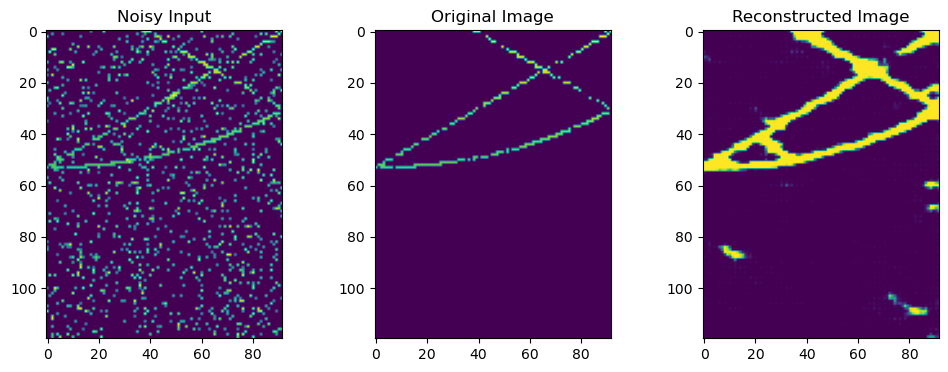

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(next(iter(test_dataloader))[0].squeeze(0).squeeze(0).to("cpu"))
ax[1].imshow(next(iter(test_dataloader))[1].squeeze(0).squeeze(0).to("cpu"))
ax[2].imshow(pred[0].squeeze(0))

ax[0].set_title("Noisy Input")
ax[1].set_title("Original Image")
ax[2].set_title("Reconstructed Image")

### Using pretrained weights

In [11]:
model.load_state_dict(torch.load("ModelWeights/HybridTransformer/hybrid_transformer_weights_1000.pth", weights_only=True))

<All keys matched successfully>

In [12]:
model.eval()

with torch.no_grad():
    pred = model.to("cpu")(next(iter(test_dataloader))[0].to("cpu"))

/home/lukelele/Documents/ResearchProject/TorchData/__init__.py:268: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.x[idx]), torch.tensor(self.y[idx])


Text(0.5, 1.0, 'Reconstructed Image')

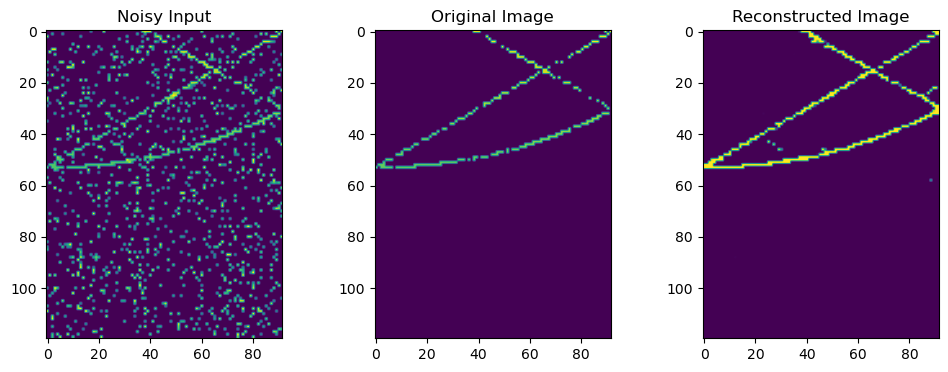

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(next(iter(test_dataloader))[0].squeeze(0).squeeze(0).to("cpu"))
ax[1].imshow(next(iter(test_dataloader))[1].squeeze(0).squeeze(0).to("cpu"))
ax[2].imshow(pred[0].squeeze(0))

ax[0].set_title("Noisy Input")
ax[1].set_title("Original Image")
ax[2].set_title("Reconstructed Image")